In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return beta * torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

beta = 0.08

kl_weight = 128/len(trainset)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kl_weight * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.10it/s]


Epoch: 0 - TrainRecLoss: 216.89806422902578 - ValidRecLoss: 181.16867799396758
Epoch: 0 - TrainDivLoss: 5.427816607157336 - ValidDivLoss: 10.324862957000732


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 145.57it/s]


Epoch: 1 - TrainRecLoss: 176.58329948636768 - ValidRecLoss: 171.56949026373368
Epoch: 1 - TrainDivLoss: 11.573344053744252 - ValidDivLoss: 11.201295067992392


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 130.97it/s]


Epoch: 2 - TrainRecLoss: 169.91008324206257 - ValidRecLoss: 166.74119142942791
Epoch: 2 - TrainDivLoss: 10.084511673526723 - ValidDivLoss: 9.371310855768904


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.00it/s]


Epoch: 3 - TrainRecLoss: 166.24414156850722 - ValidRecLoss: 164.23253892343254
Epoch: 3 - TrainDivLoss: 8.826367217594626 - ValidDivLoss: 8.300667518301855


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.97it/s]


Epoch: 4 - TrainRecLoss: 163.84262849527127 - ValidRecLoss: 161.9524383544922
Epoch: 4 - TrainDivLoss: 8.28828247879614 - ValidDivLoss: 8.17818312403522


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.20it/s]


Epoch: 5 - TrainRecLoss: 161.86483595467834 - ValidRecLoss: 160.25267917295045
Epoch: 5 - TrainDivLoss: 8.169279718704061 - ValidDivLoss: 7.727072169509115


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.66it/s]


Epoch: 6 - TrainRecLoss: 160.30303597196078 - ValidRecLoss: 158.51201639296133
Epoch: 6 - TrainDivLoss: 8.032705544917059 - ValidDivLoss: 7.898666768134395


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.18it/s]


Epoch: 7 - TrainRecLoss: 158.92712301486083 - ValidRecLoss: 157.32531487187254
Epoch: 7 - TrainDivLoss: 7.883944257235984 - ValidDivLoss: 7.864049992983854


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.29it/s]


Epoch: 8 - TrainRecLoss: 157.70779815869037 - ValidRecLoss: 156.46074956580054
Epoch: 8 - TrainDivLoss: 7.75454404359179 - ValidDivLoss: 8.011399706707724


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.84it/s]


Epoch: 9 - TrainRecLoss: 156.69074862547265 - ValidRecLoss: 155.80240621446055
Epoch: 9 - TrainDivLoss: 7.588268541323859 - ValidDivLoss: 7.538001320030116


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.14it/s]


Epoch: 10 - TrainRecLoss: 155.65396716803122 - ValidRecLoss: 154.57633315460592
Epoch: 10 - TrainDivLoss: 7.413018457416786 - ValidDivLoss: 7.430134927170186


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.24it/s]


Epoch: 11 - TrainRecLoss: 154.78709427888458 - ValidRecLoss: 153.92303814465487
Epoch: 11 - TrainDivLoss: 7.286621447565205 - ValidDivLoss: 7.029939023754265


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 143.27it/s]


Epoch: 12 - TrainRecLoss: 154.06539471266368 - ValidRecLoss: 153.51917624171776
Epoch: 12 - TrainDivLoss: 7.0737347775685 - ValidDivLoss: 7.273454575598994


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.81it/s]


Epoch: 13 - TrainRecLoss: 153.37833155650318 - ValidRecLoss: 152.2574233043043
Epoch: 13 - TrainDivLoss: 6.955060903959946 - ValidDivLoss: 6.952252481557146


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.68it/s]


Epoch: 14 - TrainRecLoss: 152.82951231348488 - ValidRecLoss: 152.1712296884271
Epoch: 14 - TrainDivLoss: 6.87040739628806 - ValidDivLoss: 6.68915059898473


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.34it/s]


Epoch: 15 - TrainRecLoss: 152.39806758010312 - ValidRecLoss: 151.977923429465
Epoch: 15 - TrainDivLoss: 6.64359590697136 - ValidDivLoss: 6.688787913020653


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.05it/s]


Epoch: 16 - TrainRecLoss: 151.90545810463587 - ValidRecLoss: 151.47657891768444
Epoch: 16 - TrainDivLoss: 6.5928645316980035 - ValidDivLoss: 6.621080108835727


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.76it/s]


Epoch: 17 - TrainRecLoss: 151.55778399306828 - ValidRecLoss: 150.96526172493077
Epoch: 17 - TrainDivLoss: 6.483191704699226 - ValidDivLoss: 6.392347471623481


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.67it/s]


Epoch: 18 - TrainRecLoss: 151.13106170849505 - ValidRecLoss: 150.59920240957527
Epoch: 18 - TrainDivLoss: 6.383388807016141 - ValidDivLoss: 6.371981732452972


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.50it/s]


Epoch: 19 - TrainRecLoss: 150.73157646000257 - ValidRecLoss: 150.44479099708266
Epoch: 19 - TrainDivLoss: 6.37320644972421 - ValidDivLoss: 6.7090423831456825


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 136.90it/s]


Epoch: 20 - TrainRecLoss: 150.4544245673141 - ValidRecLoss: 150.58382019815565
Epoch: 20 - TrainDivLoss: 6.3526773127411476 - ValidDivLoss: 6.286248032050796


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.05it/s]


Epoch: 21 - TrainRecLoss: 150.10670585062965 - ValidRecLoss: 149.8595779998393
Epoch: 21 - TrainDivLoss: 6.264359802579575 - ValidDivLoss: 6.374942109554628


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.93it/s]


Epoch: 22 - TrainRecLoss: 149.87532781995435 - ValidRecLoss: 149.82583849943137
Epoch: 22 - TrainDivLoss: 6.237951234967978 - ValidDivLoss: 6.161803746525245


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.75it/s]


Epoch: 23 - TrainRecLoss: 149.58080098166394 - ValidRecLoss: 149.3909191662752
Epoch: 23 - TrainDivLoss: 6.153814595391247 - ValidDivLoss: 6.23166462439525


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.92it/s]


Epoch: 24 - TrainRecLoss: 149.32414408279126 - ValidRecLoss: 149.3441795638845
Epoch: 24 - TrainDivLoss: 6.164533494123772 - ValidDivLoss: 6.357988423938993


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.79it/s]


Epoch: 25 - TrainRecLoss: 149.12156664232202 - ValidRecLoss: 148.87635436239123
Epoch: 25 - TrainDivLoss: 6.138710080941857 - ValidDivLoss: 6.152100439313092


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.76it/s]


Epoch: 26 - TrainRecLoss: 148.86521469148747 - ValidRecLoss: 148.64728111556815
Epoch: 26 - TrainDivLoss: 6.104080315083583 - ValidDivLoss: 6.1438453861429725


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 143.05it/s]


Epoch: 27 - TrainRecLoss: 148.69715982205324 - ValidRecLoss: 148.9760417696796
Epoch: 27 - TrainDivLoss: 6.070189647837235 - ValidDivLoss: 5.976934783066375


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.51it/s]


Epoch: 28 - TrainRecLoss: 148.44964638651052 - ValidRecLoss: 148.83789274964153
Epoch: 28 - TrainDivLoss: 6.077600959013266 - ValidDivLoss: 6.0669900224178654


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 129.79it/s]

Epoch: 29 - TrainRecLoss: 148.3037692397388 - ValidRecLoss: 148.1031467099733
Epoch: 29 - TrainDivLoss: 6.065986467576993 - ValidDivLoss: 6.07731460015985


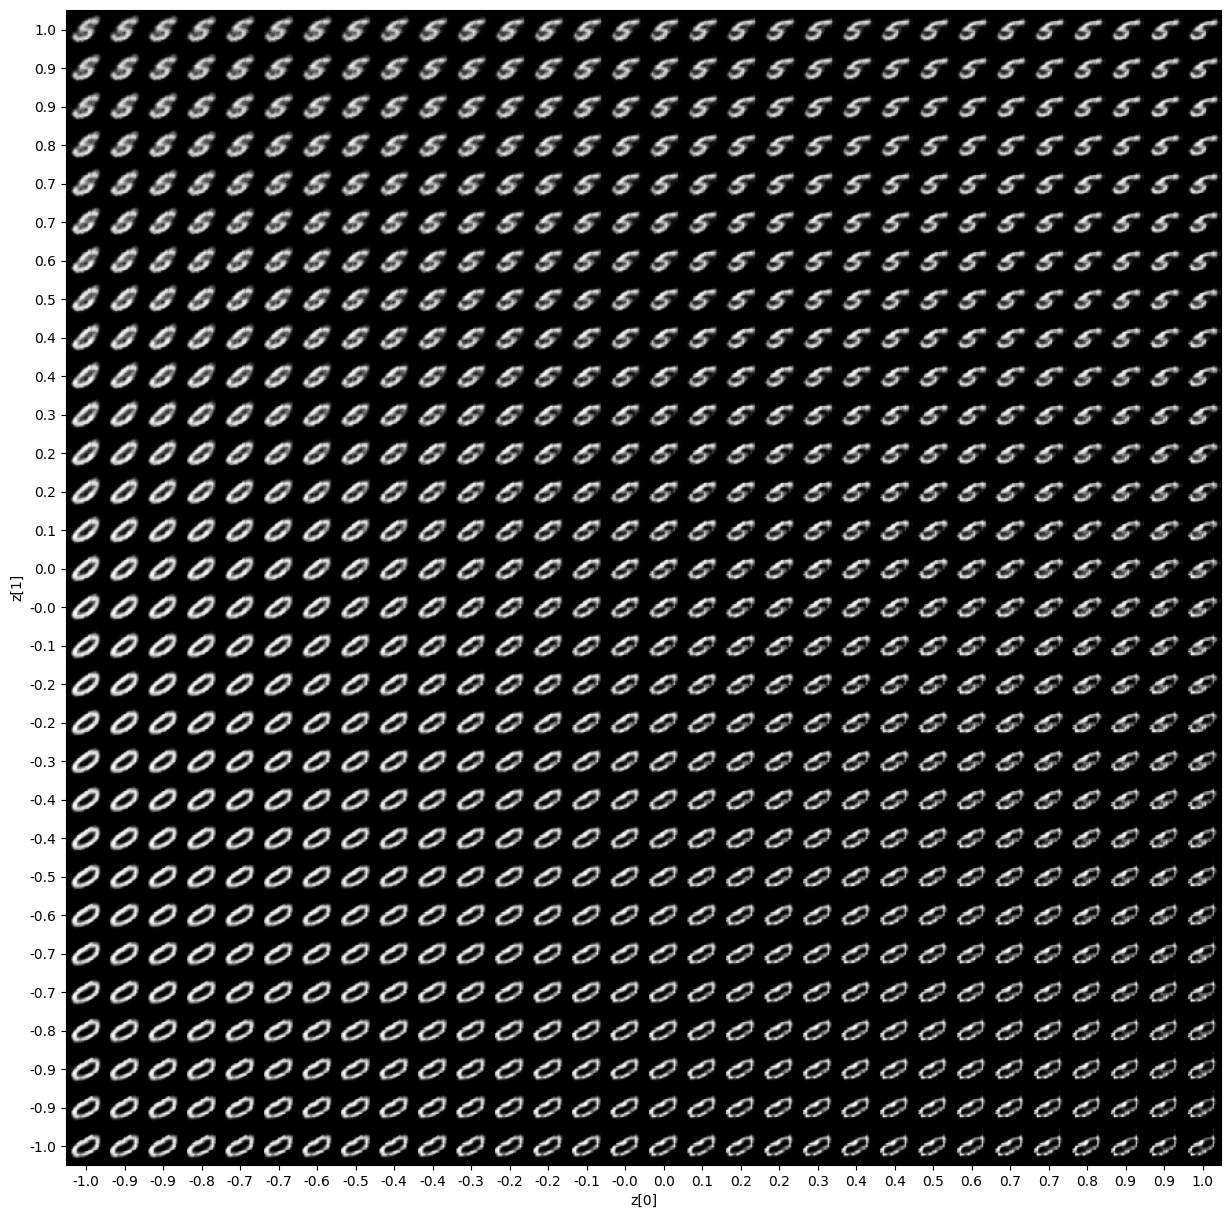

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()